In [ ]:
! pip install ultralytics
! pip install clearml

In [1]:
import glob
from ultralytics import YOLO
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import xml.etree.ElementTree as ET
from clearml import Task
import shutil
import sklearn as sk

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY= "       YOUR API KEY             "
%env CLEARML_API_SECRET_KEY= "        YOUR SECRET KEY         "

In [ ]:
task = Task.init(project_name="yolov8 training", task_name="yolo8")

In [6]:
# xml parse
PATH_TO_DATASET = ''' YOUR PATH TO DATASET '''
path_to_metadata = PATH_TO_DATASET + "/*/metadata.xml"

Mean_HHGS_Score_list =[] #будем последовательно для каждой папки записывать оценку по HHGS 
Mean_OARSI_Score_list = [] #будем послеовательно для каждой папки записывать оценку по OARSI
for file in glob.glob(path_to_metadata):
    tree = ET.parse(file)
    root = tree.getroot()    
    for Mean_HHGS_Score in root.iter('Mean_HHGS_Score'):
        attrib_dict = Mean_HHGS_Score.attrib
        val = float(attrib_dict['value'])
        Mean_HHGS_Score_list.append(val)
    for Mean_OARSI_Score in root.iter('Mean_OARSI_Score'):
        attrib_dict = Mean_OARSI_Score.attrib
        val = float(attrib_dict['value'])
        Mean_OARSI_Score_list.append(val)      

In [7]:
len(Mean_OARSI_Score_list)

90

In [11]:
path = PATH_TO_DATASET + "/*"
folders_list = [] #создадим список с названиями папок 

for folder in glob.glob(path):
    folder_link = str(folder)
    folder_name = folder_link.lstrip(path) #уберём ссылку и оставим только название 
    folders_list.append(folder_name) 
    
# создадим датафрейм с данными о пациенте, его оценке по HHGS и OARSI 
data = {'Patient_id': folders_list, 'HHGS': Mean_HHGS_Score_list, 'OARSI' : Mean_OARSI_Score_list}
df = pd.DataFrame(data) 
df.Patient_id = df.Patient_id.astype(str).str[1 :]
df.head()

,Patient_id,HHGS,OARSI
0,P001,4.0,5.0
1,P002,6.0,9.0
2,P003,4.0,4.0
3,P004,5.0,3.0
4,P005,4.0,3.0


<AxesSubplot: xlabel='HHGS', ylabel='count'>

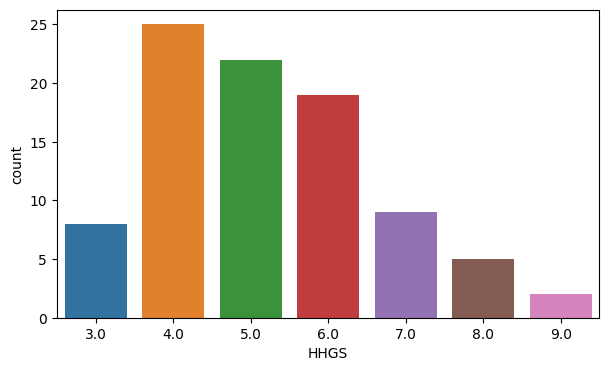

In [12]:
# распределение в датасете по оценке по HHGS 
fig, ax = plt.subplots(figsize = (7, 4))
sns.countplot(df, x= 'HHGS')

<AxesSubplot: xlabel='OARSI', ylabel='count'>

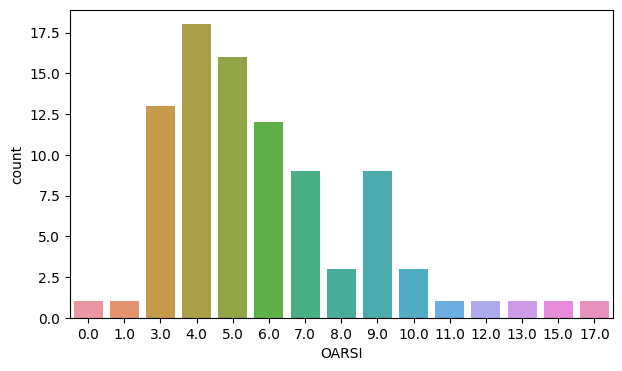

In [13]:
# распределение в датасете по оценке по OARSI
fig, ax = plt.subplots(figsize = (7, 4))
sns.countplot(df, x= 'OARSI')

Данные не сбалансированы по классам. Для формирования выборок необходима стратификация.

OARSI  score  range  was  extrapolated  from  HHGS  scores  assuming linear correlation: Mantripragada V. P. et al. High occurrence of osteoarthritic histopathological features unaccounted for by traditional scoring systems in lateral femoral condyles from total knee arthroplasty patients with varus alignment //Acta Orthopaedica. – 2018. – Т. 89. – №. 2. – С. 197-203.

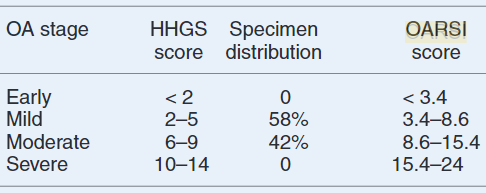

In [14]:
# сформируем список пациентов в каждом классе в соответствии с оценкой по OARSI
class_early_list= df.loc[df.OARSI < 3.4]
class_mild_list = df.query('3.4 <= OARSI < 8.6')
class_moderate_list =  df.query('8.6 <= OARSI < 15.4')
class_severe_list = df.loc[df.OARSI >= 15.4 ]

YAML формат

In [ ]:
# ├── yolo_dataset
    ## └── train
    ####└── early_OA
    #####└── images (folder including all early OA training images)
    ####└── mild_OA
    #####└── images (folder including all mild OA training images)
    ####└── moderate_OA
    #####└── images (folder including all moderate OA training images)
    ####└── severe_OA
    #####└── images (folder including all severe OA training images)
    ## └── test
    ####└── early_OA
    #####└── images (folder including all early OA testing images)
    ####└── mild_OA
    #####└── images (folder including all mild OA testing images)
    ####└── moderate_OA
    #####└── images (folder including all moderate OA testing images)
    ####└── severe_OA
    #####└── images (folder including all severe OA testing images)
    ## └── valid
    ####└── early_OA
    #####└── images (folder including all early OA validating images)    
    ####└── mild_OA
    #####└── images (folder including all mild OA validating images)
    ####└── moderate_OA
    #####└── images (folder including all moderate OA validating images)    
    ####└── severe_OA
    #####└── images (folder including all severe OA validating images)
# ├── config.yaml

HE DATASET

In [77]:
def extract_class(path_to_stained_group, path_to_img_folder, label_name):
    '''move images to class folder, create and return a Dataframe with columns: Image_name, label '''
    '''переместить изображения в папку класса, создать и вывести датафрейм с колонками: название, метка класса '''
    filenames_list = []
    for file in glob.glob(path_to_stained_group):
        shutil.move(file, path_to_img_folder)    
    for file in glob.glob(path_to_img_folder + '/*'):
        file_link = str(file)
        file_name = file_link.lstrip(path_to_img_folder)
        filenames_list.append(file_name)
    labels_set = {'Image_name': filenames_list, 'label': label_name}
    labels_set = pd.DataFrame(labels_set) 
    labels_set.Image_name = labels_set.Image_name.astype(str).str[1 :]
    
    return(labels_set)
     

In [ ]:
early_labels_set = extract_class(path_to_stained_group = "C:/ide/master/datasets/cartilage_YOLO_dataset/group_early/*/*/HE/*", path_to_img_folder = 'C:/ide/master/datasets/cartilage_YOLO_dataset/early_OA_images', label_name = "early")
mild_labels_set = extract_class(path_to_stained_group = "C:/ide/master/datasets/cartilage_YOLO_dataset/group_mild/*/*/HE/*", path_to_img_folder = 'C:/ide/master/datasets/cartilage_YOLO_dataset/mild_OA_images', label_name = "mild")
severe_labels_set = extract_class(path_to_stained_group = "C:/ide/master/datasets/cartilage_YOLO_dataset/group_severe/*/*/HE/*", path_to_img_folder = 'C:/ide/master/datasets/cartilage_YOLO_dataset/severe_OA_images', label_name = "severe")
moderate_labels_set = extract_class(path_to_stained_group = "C:/ide/master/datasets/cartilage_YOLO_dataset/group_moderate/*/*/HE/*", path_to_img_folder = 'C:/ide/master/datasets/cartilage_YOLO_dataset/moderate_OA_images', label_name = "moderate")

In [80]:
moderate_labels_set.head()

,Image_name,label
0,HE 100 section 1.tif,moderate
1,HE 100 section 3.tif,moderate
2,"HE 105, section 1.tif",moderate
3,"HE 105, section 3.tif",moderate
4,"HE 106, section 1.tif",moderate


In [81]:
merged_set = pd.concat([early_labels_set, mild_labels_set, moderate_labels_set, severe_labels_set], ignore_index=True)

In [82]:
merged_set.to_excel('output.xlsx')

Стратифицированная выборка: 70-20-10

In [83]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(merged_set.Image_name, merged_set.label, train_size=0.9, random_state=42, stratify = merged_set.label)

In [84]:
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X_train, y_train, train_size=0.78, random_state=42, stratify = y_train)

In [85]:
train_set = pd.DataFrame({'Image_name': X_train, 'label': y_train})
train_set = train_set.reset_index(drop=True)
train_set

,Image_name,label
0,"HE 35, section 3.tif",moderate
1,"HE-175, section 1.tif",mild
2,HE 78 section 3.tif,mild
3,"HE 115, section 1.tif",moderate
4,HE 102 section 1.tif,mild
...,...,...
240,"HE 44, section 3.tif",mild
241,HE 59 section 3.tif,moderate
242,"HE7, section 3.tif",early
243,"HE-167, section 1.tif",mild


In [86]:
test_set = pd.DataFrame({'Image_name': X_test, 'label': y_test}) 
test_set = test_set.reset_index(drop=True)
test_set

,Image_name,label
0,"HE 125, section 1.tif",mild
1,"HE 129, section 3.tif",mild
2,"HE 85, section 3.tif",mild
3,HE 60 section 1.tif,moderate
4,"HE 131, section 1.tif",severe
5,HE 93 section 3.tif,mild
6,HE 69 section 1.tif,moderate
7,"HE-173, section 1.tif",mild
8,HE 48 section 1.tif,mild
9,HE 102 section 3.tif,mild


In [87]:
val_set = pd.DataFrame({'Image_name': X_val, 'label': y_val})
val_set = val_set.reset_index(drop = True)
len(val_set)

70

## MODEL

## Classification

In [98]:
HE_m_model = YOLO('yolov8m-cls.pt')

New https://pypi.org/project/ultralytics/8.2.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.15 🚀 Python-3.9.10 torch-2.1.1+cpu CPU (Intel Core(TM) i3-10110U 2.10GHz)
engine\trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=C:/ide/master/datasets/cartilage_YOLO_dataset/HE_dataset/, epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

train: Scanning C:\ide\master\datasets\cartilage_YOLO_dataset\HE_dataset\train... 245 images, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]
val: Scanning C:\ide\master\datasets\cartilage_YOLO_dataset\HE_dataset\val... 70 images, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)


Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\classify\train4
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:45<00:00, 35.21s/it]

                   all      0.629          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:46<00:00, 35.59s/it]

                   all      0.643          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:45<00:00, 35.13s/it]

                   all      0.629          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:45<00:00, 35.25s/it]

                   all      0.729          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:46<00:00, 35.42s/it]

                   all      0.657          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:44<00:00, 34.86s/it]

                   all      0.771          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:44<00:00, 34.83s/it]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.85s/it]


                   all      0.771          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.40s/it]

                   all      0.814          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50         0G     0.3458          5        640: 100%|██████████| 16/16 [16:22<00:00, 61.43s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.41s/it]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50         0G     0.2862          5        640: 100%|██████████| 16/16 [16:50<00:00, 63.15s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:48<00:00, 36.33s/it]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50         0G     0.2555          5        640: 100%|██████████| 16/16 [16:19<00:00, 61.22s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.72s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50         0G     0.2738          5        640: 100%|██████████| 16/16 [16:25<00:00, 61.58s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.45s/it]

                   all      0.857          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50         0G     0.2313          5        640: 100%|██████████| 16/16 [16:28<00:00, 61.81s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:48<00:00, 36.26s/it]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50         0G     0.1529          5        640: 100%|██████████| 16/16 [16:12<00:00, 60.81s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.41s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50         0G     0.1602          5        640: 100%|██████████| 16/16 [16:28<00:00, 61.76s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.39s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50         0G     0.1518          5        640: 100%|██████████| 16/16 [16:20<00:00, 61.31s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.64s/it]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50         0G     0.1403          5        640: 100%|██████████| 16/16 [16:27<00:00, 61.71s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.60s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50         0G     0.1141          5        640: 100%|██████████| 16/16 [16:10<00:00, 60.68s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.57s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50         0G      0.102          5        640: 100%|██████████| 16/16 [16:18<00:00, 61.14s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.35s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50         0G     0.1433          5        640: 100%|██████████| 16/16 [16:35<00:00, 62.19s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:48<00:00, 36.28s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50         0G     0.1214          5        640: 100%|██████████| 16/16 [16:26<00:00, 61.64s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.71s/it]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50         0G    0.07254          5        640: 100%|██████████| 16/16 [16:32<00:00, 62.04s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.34s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50         0G    0.08377          5        640: 100%|██████████| 16/16 [16:57<00:00, 63.58s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.47s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50         0G     0.1066          5        640: 100%|██████████| 16/16 [16:22<00:00, 61.38s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.44s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50         0G     0.1393          5        640: 100%|██████████| 16/16 [16:25<00:00, 61.58s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.48s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50         0G    0.09628          5        640: 100%|██████████| 16/16 [16:20<00:00, 61.30s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:54<00:00, 38.17s/it]

                   all      0.857          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50         0G     0.1067          5        640: 100%|██████████| 16/16 [16:31<00:00, 61.95s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.39s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50         0G    0.06425          5        640: 100%|██████████| 16/16 [16:26<00:00, 61.63s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.61s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50         0G    0.06004          5        640: 100%|██████████| 16/16 [16:28<00:00, 61.80s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.67s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50         0G    0.05191          5        640: 100%|██████████| 16/16 [16:37<00:00, 62.37s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.52s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50         0G    0.07077          5        640: 100%|██████████| 16/16 [16:38<00:00, 62.42s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:48<00:00, 36.30s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50         0G    0.06296          5        640: 100%|██████████| 16/16 [16:34<00:00, 62.18s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.50s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50         0G     0.1309          5        640: 100%|██████████| 16/16 [16:32<00:00, 62.05s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.54s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50         0G    0.06172          5        640: 100%|██████████| 16/16 [16:42<00:00, 62.65s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.57s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50         0G    0.07108          5        640: 100%|██████████| 16/16 [16:44<00:00, 62.81s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.61s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50         0G    0.03148          5        640: 100%|██████████| 16/16 [16:52<00:00, 63.28s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.44s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50         0G    0.03209          5        640: 100%|██████████| 16/16 [16:33<00:00, 62.10s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.72s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50         0G    0.02344          5        640: 100%|██████████| 16/16 [16:31<00:00, 61.98s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.58s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50         0G    0.04115          5        640: 100%|██████████| 16/16 [16:35<00:00, 62.23s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:53<00:00, 37.95s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50         0G    0.02663          5        640: 100%|██████████| 16/16 [16:37<00:00, 62.35s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.92s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50         0G    0.05673          5        640: 100%|██████████| 16/16 [16:37<00:00, 62.35s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.82s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50         0G    0.02537          5        640: 100%|██████████| 16/16 [16:19<00:00, 61.22s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.47s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50         0G    0.06818          5        640: 100%|██████████| 16/16 [17:00<00:00, 63.75s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.47s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50         0G    0.04156          5        640: 100%|██████████| 16/16 [16:36<00:00, 62.29s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.51s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50         0G      0.044          5        640: 100%|██████████| 16/16 [16:37<00:00, 62.37s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.64s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50         0G    0.03335          5        640: 100%|██████████| 16/16 [16:44<00:00, 62.76s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.70s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50         0G    0.02489          5        640: 100%|██████████| 16/16 [16:38<00:00, 62.40s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:48<00:00, 36.19s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50         0G    0.05494          5        640: 100%|██████████| 16/16 [16:40<00:00, 62.51s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.27s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50         0G    0.04751          5        640: 100%|██████████| 16/16 [17:13<00:00, 64.59s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.41s/it]

                   all      0.929          1



50 epochs completed in 15.309 hours.
Optimizer stripped from runs\classify\train4\weights\last.pt, 31.7MB
Optimizer stripped from runs\classify\train4\weights\best.pt, 31.7MB

Validating runs\classify\train4\weights\best.pt...
Ultralytics YOLOv8.1.15 🚀 Python-3.9.10 torch-2.1.1+cpu CPU (Intel Core(TM) i3-10110U 2.10GHz)
YOLOv8m-cls summary (fused): 103 layers, 15767780 parameters, 0 gradients, 41.6 GFLOPs
train: C:\ide\master\datasets\cartilage_YOLO_dataset\HE_dataset\train... found 245 images in 4 classes ✅ 
val: C:\ide\master\datasets\cartilage_YOLO_dataset\HE_dataset\val... found 70 images in 4 classes ✅ 
test: C:\ide\master\datasets\cartilage_YOLO_dataset\HE_dataset\test... found 36 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:46<00:00, 35.65s/it]


                   all      0.957          1
Speed: 0.0ms preprocess, 659.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train4
Results saved to runs\classify\train4
2024-04-20 16:47:19,874 - clearml.storage - INFO - Starting upload: runs\classify\train4\weights\best.pt => https://files.clear.ml/cart_classification/yolo8s-cls.fabca85a3daa4d14b29d097021a3fea5/models/best.pt


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000016E0AA82670>
curves: []
curves_results: []
fitness: 0.9785714149475098
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9571428298950195, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9785714149475098}
save_dir: WindowsPath('runs/classify/train4')
speed: {'preprocess': 0.0, 'inference': 659.8957606724331, 'loss': 0.0, 'postprocess': 0.0}
task: 'classify'
top1: 0.9571428298950195
top5: 1.0

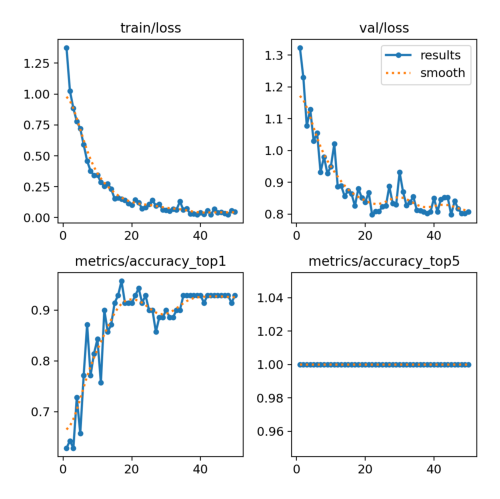

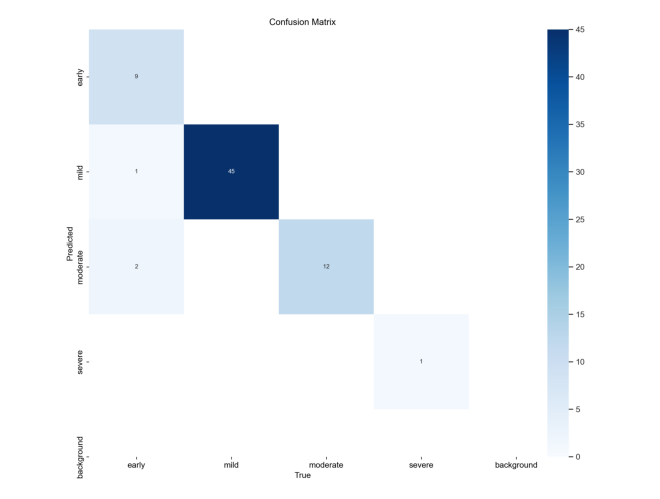

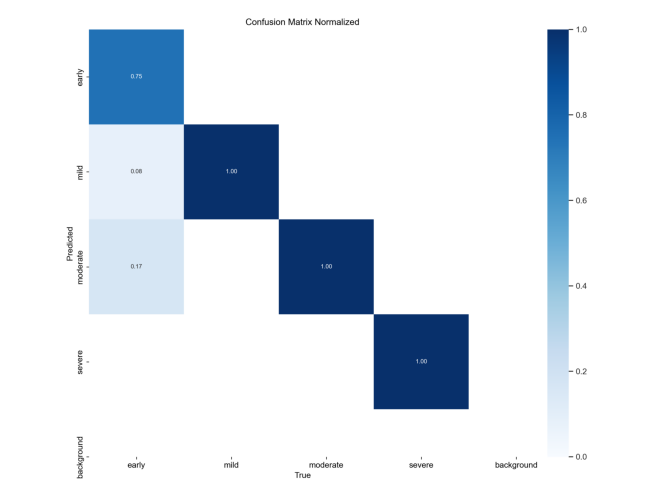

In [99]:
HE_m_model.train(data="C:/ide/master/datasets/cartilage_YOLO_dataset/HE_dataset/", imgsz = 640, epochs=50, cls = 0.5, hsv_h = 0.015,
hsv_s = 0.1,
hsv_v = 0.1,
translate = 0.1,
scale = 0.1,
shear = 0.0,
degrees = 180,
perspective = 0.0001,
flipud = 0.2,
fliplr = 0.2,
mosaic = 1.0,
mixup = 0.05,
copy_paste = 0.05,
erasing = 0.1,
crop_fraction = 1.0
) 

In [73]:
s_c_model = YOLO('yolov8m-cls.pt')

In [74]:
s_c_model.train(data="C:/ide/master/datasets/cartilage_YOLO_dataset/SafO_dataset/", imgsz = 640, epochs=50, cls = 0.5, hsv_h = 0.015,
hsv_s = 0.1,
hsv_v = 0.1,
translate = 0.1,
scale = 0.1,
shear = 0.0,
degrees = 180,
perspective = 0.0001,
flipud = 0.2,
fliplr = 0.2,
mosaic = 1.0,
mixup = 0.05,
erasing = 0.1,
crop_fraction = 1.0
) 

New https://pypi.org/project/ultralytics/8.2.1 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.15 🚀 Python-3.9.10 torch-2.1.1+cpu CPU (Intel Core(TM) i3-10110U 2.10GHz)
engine\trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=C:/ide/master/datasets/cartilage_YOLO_dataset/SafO_dataset/, epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

train: Scanning C:\ide\master\datasets\cartilage_YOLO_dataset\SafO_dataset\train... 244 images, 1 corrupt: 100%|██████████| 244/244 [00:00<?, ?it/s]

train: WARNING ⚠️ C:\ide\master\datasets\cartilage_YOLO_dataset\SafO_dataset\train\mild\SafO-173, section 4.tif: ignoring corrupt image/label: Image size (182377924 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.



val: Scanning C:\ide\master\datasets\cartilage_YOLO_dataset\SafO_dataset\val... 70 images, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\classify\train2
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:44<00:00, 34.75s/it]

                   all      0.671          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:46<00:00, 35.47s/it]

                   all      0.643          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.00s/it]

                   all      0.643          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.13s/it]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.17s/it]

                   all      0.786          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.80s/it]

                   all      0.814          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.76s/it]

                   all      0.857          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.94s/it]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.83s/it]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50         0G     0.3569          4        640: 100%|██████████| 16/16 [15:50<00:00, 59.39s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.72s/it]

                   all      0.814          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50         0G     0.3115          4        640: 100%|██████████| 16/16 [15:43<00:00, 58.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:49<00:00, 36.66s/it]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50         0G     0.2544          4        640: 100%|██████████| 16/16 [15:35<00:00, 58.49s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.37s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50         0G     0.1968          4        640: 100%|██████████| 16/16 [15:42<00:00, 58.94s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.73s/it]

                   all      0.857          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50         0G     0.2318          4        640: 100%|██████████| 16/16 [17:59<00:00, 67.44s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.79s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50         0G     0.1215          4        640: 100%|██████████| 16/16 [16:08<00:00, 60.52s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.72s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50         0G     0.2139          4        640: 100%|██████████| 16/16 [16:21<00:00, 61.37s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.13s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50         0G     0.1491          4        640: 100%|██████████| 16/16 [16:17<00:00, 61.11s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:54<00:00, 38.33s/it]

                   all      0.857          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50         0G     0.1312          4        640: 100%|██████████| 16/16 [16:18<00:00, 61.17s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.29s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50         0G     0.1672          4        640: 100%|██████████| 16/16 [16:21<00:00, 61.32s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.22s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50         0G     0.1024          4        640: 100%|██████████| 16/16 [16:18<00:00, 61.16s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.31s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50         0G     0.1298          4        640: 100%|██████████| 16/16 [16:15<00:00, 60.97s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.05s/it]


                   all        0.9          1

      Epoch    GPU_mem       loss  Instances       Size


      22/50         0G     0.1239          4        640: 100%|██████████| 16/16 [16:21<00:00, 61.37s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.19s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50         0G     0.1231          4        640: 100%|██████████| 16/16 [16:23<00:00, 61.45s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.14s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50         0G     0.1833          4        640: 100%|██████████| 16/16 [16:22<00:00, 61.38s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.04s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50         0G      0.103          4        640: 100%|██████████| 16/16 [16:12<00:00, 60.78s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.34s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50         0G    0.07716          4        640: 100%|██████████| 16/16 [16:23<00:00, 61.49s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.35s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50         0G    0.09249          4        640: 100%|██████████| 16/16 [16:16<00:00, 61.01s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:55<00:00, 38.64s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50         0G     0.1429          4        640: 100%|██████████| 16/16 [16:29<00:00, 61.87s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.24s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50         0G    0.05567          4        640: 100%|██████████| 16/16 [16:24<00:00, 61.52s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.09s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50         0G     0.1161          4        640: 100%|██████████| 16/16 [16:16<00:00, 61.00s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.37s/it]

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50         0G    0.07568          4        640: 100%|██████████| 16/16 [16:25<00:00, 61.62s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.29s/it]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50         0G    0.08419          4        640: 100%|██████████| 16/16 [16:21<00:00, 61.36s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:50<00:00, 36.91s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50         0G    0.05577          4        640: 100%|██████████| 16/16 [16:22<00:00, 61.44s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.31s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50         0G    0.04235          4        640: 100%|██████████| 16/16 [16:30<00:00, 61.88s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.20s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50         0G     0.1015          4        640: 100%|██████████| 16/16 [16:21<00:00, 61.32s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:53<00:00, 37.88s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50         0G     0.0908          4        640: 100%|██████████| 16/16 [16:21<00:00, 61.34s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.58s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50         0G    0.05724          4        640: 100%|██████████| 16/16 [16:27<00:00, 61.74s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.45s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50         0G    0.05219          4        640: 100%|██████████| 16/16 [16:18<00:00, 61.17s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.49s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50         0G    0.06567          4        640: 100%|██████████| 16/16 [16:26<00:00, 61.67s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:52<00:00, 37.55s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50         0G    0.02805          4        640: 100%|██████████| 16/16 [16:26<00:00, 61.66s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:57<00:00, 39.07s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50         0G    0.03804          4        640: 100%|██████████| 16/16 [16:22<00:00, 61.43s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.30s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50         0G    0.04119          4        640: 100%|██████████| 16/16 [16:20<00:00, 61.28s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.15s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50         0G    0.06083          4        640: 100%|██████████| 16/16 [16:16<00:00, 61.05s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.16s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50         0G    0.04063          4        640: 100%|██████████| 16/16 [16:31<00:00, 61.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.25s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50         0G    0.04815          4        640: 100%|██████████| 16/16 [16:26<00:00, 61.63s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.05s/it]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50         0G    0.03651          4        640: 100%|██████████| 16/16 [16:31<00:00, 61.97s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.20s/it]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50         0G    0.02844          4        640: 100%|██████████| 16/16 [16:26<00:00, 61.67s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.04s/it]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50         0G    0.02784          4        640: 100%|██████████| 16/16 [16:17<00:00, 61.09s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.01s/it]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50         0G    0.02772          4        640: 100%|██████████| 16/16 [16:29<00:00, 61.82s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.25s/it]


                   all      0.943          1

      Epoch    GPU_mem       loss  Instances       Size


      50/50         0G    0.04155          4        640: 100%|██████████| 16/16 [16:22<00:00, 61.38s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:51<00:00, 37.05s/it]

                   all      0.943          1



50 epochs completed in 15.173 hours.
Optimizer stripped from runs\classify\train2\weights\last.pt, 31.7MB
Optimizer stripped from runs\classify\train2\weights\best.pt, 31.7MB

Validating runs\classify\train2\weights\best.pt...
Ultralytics YOLOv8.1.15 🚀 Python-3.9.10 torch-2.1.1+cpu CPU (Intel Core(TM) i3-10110U 2.10GHz)
YOLOv8m-cls summary (fused): 103 layers, 15767780 parameters, 0 gradients, 41.6 GFLOPs
train: C:\ide\master\datasets\cartilage_YOLO_dataset\SafO_dataset\train... found 245 images in 4 classes ✅ 
val: C:\ide\master\datasets\cartilage_YOLO_dataset\SafO_dataset\val... found 70 images in 4 classes ✅ 
test: C:\ide\master\datasets\cartilage_YOLO_dataset\SafO_dataset\test... found 35 images in 3 classes: ERROR ❌️ requires 4 classes, not 3


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [01:46<00:00, 35.38s/it]


                   all      0.943          1
Speed: 0.0ms preprocess, 647.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train2
Results saved to runs\classify\train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000016E22225E50>
curves: []
curves_results: []
fitness: 0.9714285731315613
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9428571462631226, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9714285731315613}
save_dir: WindowsPath('runs/classify/train2')
speed: {'preprocess': 0.0, 'inference': 647.018439429147, 'loss': 0.0, 'postprocess': 0.0}
task: 'classify'
top1: 0.9428571462631226
top5: 1.0